In [1]:
import pickle
import os
import random
from tqdm import tqdm, trange

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from utils.KeywordRepresentationGenerator import KeywordRepresentationGenerator
from utils.BiasSubspaceGenerator import BiasSubspaceGenerator
from utils.SentenceEncoder import SentenceEncoder
from utils.parse_word_files import parse_word_files
from utils.Visualize import Visualize

# Settings

In [2]:
s_LM = "KOR_BERT" # Determines the base Sentence Encoder to use

s_PRINT_CRUCIAL = True # If selected, print crucial informations
s_PRINT_DEBUG = True # If selected, print debug informations

s_PRINT_TQDM_PER_FILE_BSG = True # If selected, print tqdm bars for loadData_WPS per file
s_PRINT_TQDM_PER_SENTENCE_BSG = False # If selected, print tqdm bars for loadData_WPS per sentence

s_PRINT_TQDM_PER_SENTENCE_PAIR_BSG = True # If selected, print tqdm bars for get_bias_subspace
s_MAX_SENTENCE_LENGTH = 500 # Determines the maximum length of sentence (numbers of word) (currently only works for get_bias_subspace)

s_PRINT_TQDM_PER_FILE_KRG = False # If selected, print tqdm bars for loadData_VSK per file
s_PRINT_TQDM_PER_SENTENCE_KRG = True # If selected, print tqdm bars for loadData_VSK per sentence

s_MAX_LENGTH_PER_FILE_BSG = 4 # Determines the max length(numbers) of sentence
s_MAX_LENGTH_PER_KEYWORD_KRG = 200 # Determines the max length(numbers) of sentence

s_FONTPATH = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc' # Determines the fontpath for visualization
s_FONTSIZE = 9 # Determines the fontpath for visualization

s_RANDOM=True # If selected, there will be random operation in needed place
s_SAVE_LATENT_FILES = True  # If selected, latent files will be saved under /latent_files/

# Loading Words

In [3]:
if(s_LM=="KOR_BERT"):
    SE = SentenceEncoder('kykim/bert-kor-base')
elif(s_LM=="KR_BERT"):
    SE = SentenceEncoder('snunlp/KR-BERT-char16424')
elif(s_LM=="KLUE_BERT"):
    SE = SentenceEncoder("klue/bert-base")
else:
    SE = SentenceEncoder("klue/bert-base")

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
word_set = []
word_pair_set = []
v_keyword_set = {}

word_set, word_pair_set,v_keyword_set = parse_word_files(SE,"Texts/"+s_LM+"/"+"VisualizationKeywords.txt", "Texts/"+s_LM+"/"+"WordPairs.txt",s_PRINT_CRUCIAL,s_PRINT_DEBUG)

All word pairs are single token.

['남자', '남자는', '남자가', '남자의', '여자', '여자는', '여자가', '여자의', '컴퓨터', '컴퓨터를', '컴퓨터가', '화장', '화장을', '화장이', '음악', '음악을', '음악이', '연구', '연구를', '연구가', '회사', '회사가', '회사에서', '회사를', '회사로', '가정', '가정의', '가정에서', '운동', '운동을', '운동은', '일', '일을', '일이', '직장', '축구', '꽃', '꽃은', '꽃이', '꽃을', '집', '요리', '담배', '담배를', '농구', '치마', '바지', '남자', '여자', '남자는', '여자는', '남자가', '여자가', '남자의', '여자의', '남성', '여성', '남성이', '여성이', '남성의', '여성의', '할아버지', '할머니', '아버지', '어머니', '아버지는', '어머니는', '아버지의', '어머니의', '아버지가', '어머니가', '아들', '딸', '아들은', '딸은', '아들의', '딸의', '아들이', '딸이', '그', '그녀', '그가', '그녀가', '그의', '그녀의', '그는', '그녀는']

[('남자', '여자'), ('남자는', '여자는'), ('남자가', '여자가'), ('남자의', '여자의'), ('남성', '여성'), ('남성이', '여성이'), ('남성의', '여성의'), ('할아버지', '할머니'), ('아버지', '어머니'), ('아버지는', '어머니는'), ('아버지의', '어머니의'), ('아버지가', '어머니가'), ('아들', '딸'), ('아들은', '딸은'), ('아들의', '딸의'), ('아들이', '딸이'), ('그', '그녀'), ('그가', '그녀가'), ('그의', '그녀의'), ('그는', '그녀는')]

{'남자': ['남자', '남자는', '남자가', '남자의'], '여자': ['여자', '여자는', '여자가', '여자의'], '컴

# Bias Subspace Generation

In [5]:
BSG = BiasSubspaceGenerator(SE)

dir1 = "../DataSet_GBS/" #directory of getting bias subspace
# dir1 = "../KrDataSet/EveryText/WrittenText/"
file_list = os.listdir(dir1)

s = []
for file in (tqdm(file_list,desc="loading files for Bias Subspace Generator") if s_PRINT_TQDM_PER_FILE_BSG else file_list) :
    if(file.endswith("pkl")):
        a=(BSG.loadData_WPS(dir1+file,word_pair_set,s_MAX_LENGTH_PER_FILE_BSG, s_PRINT_TQDM_PER_SENTENCE_BSG))
        s+=a

loading files for Bias Subspace Generator: 100%|██████████| 20188/20188 [02:56<00:00, 114.44it/s]


In [6]:
vectors = BSG.get_bias_vectors(s,s_MAX_SENTENCE_LENGTH,s_PRINT_TQDM_PER_SENTENCE_PAIR_BSG)

if(s_SAVE_LATENT_FILES):
    with open('./latent_files/gbs_vectors_2d.pkl', 'wb') as f:
        pickle.dump(vectors, f)

getting bias vectors from sentence pairs: 100%|██████████| 8743/8743 [13:38<00:00, 10.68it/s]


In [7]:
print(len(vectors))

17486


In [8]:
pca = PCA(n_components=10)
result = pca.fit(vectors)
result = result.components_[:10]

In [9]:
print(result)
SE.set_bias_subspace(result)

with open( "./latent_files/bias_subspace_d2_opt_10.pkl", 'wb') as f:
    pickle.dump(result, f)

[[ 0.02306186  0.01494975  0.03827432 ...  0.02274771 -0.01643931
   0.01834079]
 [-0.03498824 -0.03338508  0.05252717 ... -0.01059337  0.03127378
  -0.00845493]
 [-0.00636433  0.00406903  0.02646202 ... -0.01119496 -0.02979273
   0.02741661]
 ...
 [-0.03137252 -0.00319741  0.02113699 ...  0.00125747  0.06683511
  -0.05529405]
 [-0.01232479  0.04314235  0.01305327 ...  0.06568982 -0.05967814
  -0.0558405 ]
 [-0.02529402 -0.02443349  0.02292751 ...  0.02280346 -0.02683126
   0.00154524]]


In [10]:
# with open( "./latent_files/bias_subspace_d2_opt_10.pkl", 'rb') as f:
#     result = pickle.load(f)
# SE.set_bias_subspace(result)

# Getting Keyword Representations

In [11]:
KRG = KeywordRepresentationGenerator(SE)
dir2 = "../DataSet_GKR/" #directory of getting keyword representations

total = {}
file_list2 = os.listdir(dir2)
for file in (tqdm(file_list2) if s_PRINT_TQDM_PER_FILE_KRG else(file_list2)):
    if(file.endswith('.pkl')):
        total.update(KRG.loadData_VSK(dir2+file,v_keyword_set,s_PRINT_TQDM_PER_SENTENCE_KRG))

100%|██████████| 3300370/3300370 [13:29<00:00, 4075.24it/s]


In [12]:
for i in total:
    print(i,len(total[i]))

with open( "./latent_files/total.pkl", 'wb') as f:
    pickle.dump(total, f)

남자 6141
여자 6724
컴퓨터 3050
화장 534
음악 10505
연구 41323
회사 14356
가정 11088
운동 8895
일 46920
직장 4339
축구 6894
꽃 6611
집 13014
요리 2788
담배 2063
농구 1059
치마 151
바지 593


In [13]:
# KRG = KeywordRepresentationGenerator(SE)
# with open( "./latent_files/total.pkl", 'rb') as f:
#     total = pickle.load(f)

In [14]:
keyword_reps, debiased_keyword_reps = KRG.get_both_keyword_reps(total, maxl=s_MAX_LENGTH_PER_KEYWORD_KRG,do_random=s_RANDOM)    

if(s_SAVE_LATENT_FILES):
    with open('./latent_files/KeywordReps_not_normed.pkl', 'wb') as f:
        pickle.dump(keyword_reps, f)
    with open('./latent_files/Debiased_KeywordReps_not_normed.pkl', 'wb') as f:
        pickle.dump(debiased_keyword_reps, f)

modeling 바지: 100%|██████████| 200/200 [00:24<00:00,  8.30it/s]


In [15]:
# KRG = KeywordRepresentationGenerator(SE)
# with open('./latent_files/KeywordReps_not_normed.pkl', 'rb') as f:
#     keyword_reps = pickle.load(f)
# with open('./latent_files/Debiased_KeywordReps_not_normed.pkl', 'rb') as f:
#     debiased_keyword_reps = pickle.load(f)
    
# for i in keyword_reps:
#     print(i,len(keyword_reps[i]))
# for i in debiased_keyword_reps:
#     print(i,len(debiased_keyword_reps[i]))

In [16]:
original_avg_2d = KRG.norm_and_reduce(keyword_reps,s_PRINT_DEBUG)
debiased_avg_2d = KRG.norm_and_reduce(debiased_keyword_reps,s_PRINT_DEBUG)
with open('./result/keyword2d.pkl', 'wb') as f:
    pickle.dump((original_avg_2d,debiased_avg_2d),f)

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 151, 200]
tSNE complete
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 151, 200]
tSNE complete


 # Visualize

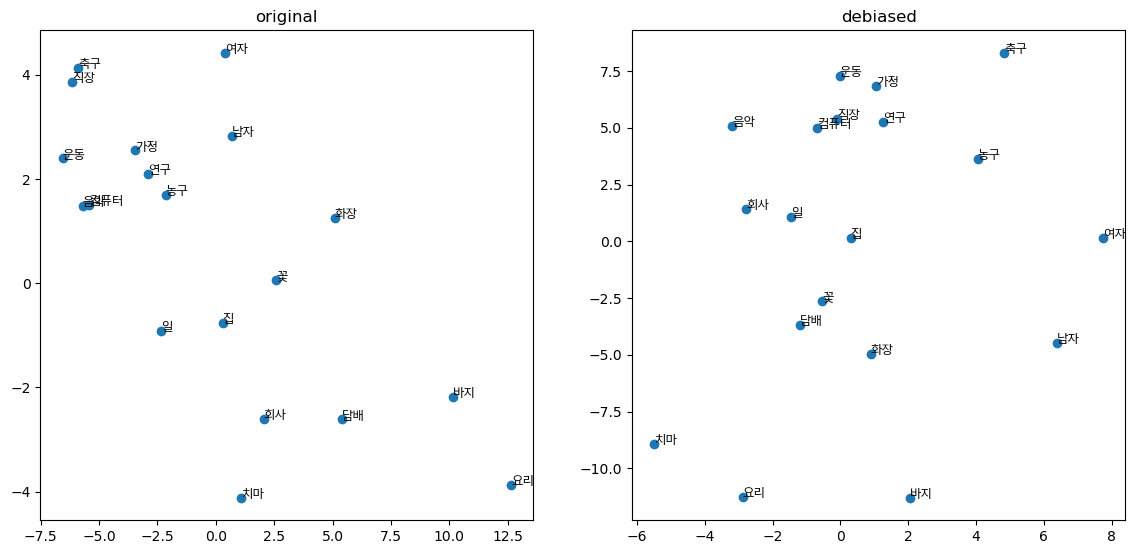

In [17]:
Visualize(s_FONTPATH, s_FONTSIZE, original_avg_2d, debiased_avg_2d)